## CS 6120: Predicting Retraction Paper

## Importing the Libraries

In [20]:
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
from sklearn.utils import resample
import string
import math
from sklearn.metrics import roc_curve

warnings.filterwarnings("ignore")

## Reading the data

 

In [2]:
## Reading the data and removing columns that are not important. 
df = pd.read_csv('retraction3.csv', sep = ',', encoding = 'latin-1', usecols = lambda col: col not in ["Unnamed: 0"])


In [3]:
df.head()

,Target,Text
0,1,farzaneh terumi kohwi shigematsu oliver bisch...
1,1,saenz ausejo mataix fernandez esteban rojas e...
2,1,vol august pp doiclim available online simult...
3,1,download university lethbridge date november ...
4,1,synthesis global regulator fis ro n gareth pa...


## Count plot of the output categories: retracted or no-retracted



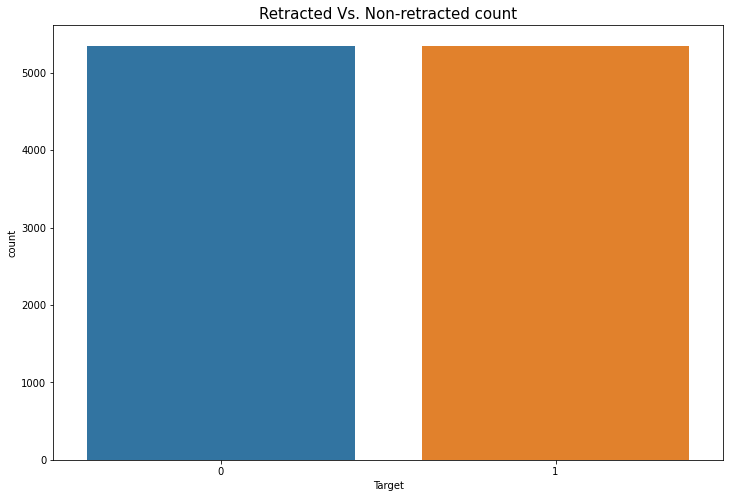

In [4]:
plt.figure(figsize = (12,8))
sns.countplot(x ='Target', data = df)
plt.title("Retracted Vs. Non-retracted count", fontsize = 15)
plt.show()

## Upsampling the minority class



In [5]:
from sklearn.utils import resample

df_majority = df[df.Target==0]
df_minority = df[df.Target==1]

spam_upsample = resample(df_minority, replace = True, 
                        n_samples = df_majority.shape[0],
                        random_state = 101)

df_upsampled = pd.concat([df_majority, spam_upsample])  
df_upsampled = df_upsampled.sample(frac = 1)

In [6]:
df_upsampled[df_upsampled['Target']==0].shape

(5349, 2)

In [7]:
df_upsampled[df_upsampled['Target']==1].shape

(5349, 2)

## Vectorization

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split,StratifiedKFold
sentences = df_upsampled['Text'].tolist()
vectorizer = CountVectorizer()
#vectorizer = CountVectorizer(max_features = 3)
X = vectorizer.fit_transform(sentences)
y = df_upsampled['Target'].tolist()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, stratify = y, random_state = 123)

In [14]:
print(X.shape)
print(X_train.shape)
print(X_test.shape)

(10698, 564983)
(8558, 564983)
(2140, 564983)


## Training and Evaluating Models
# Random Forest classification

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

m1 = 'Random Forest Classfier'
rf = RandomForestClassifier(n_estimators=50, random_state=12,max_depth=3)
rf.fit(X_train,y_train)
rf_predicted = rf.predict(X_test)
rf_conf_matrix = confusion_matrix(y_test, rf_predicted)
rf_acc_score = accuracy_score(y_test, rf_predicted)
print("confussion matrix")
print(rf_conf_matrix)
print("\n")
print("Accuracy of Random Forest:",rf_acc_score*100,'\n')
print(classification_report(y_test,rf_predicted))

confussion matrix
[[1020   50]
 [  49 1021]]


Accuracy of Random Forest: 95.37383177570094 

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1070
           1       0.95      0.95      0.95      1070

    accuracy                           0.95      2140
   macro avg       0.95      0.95      0.95      2140
weighted avg       0.95      0.95      0.95      2140



## Naive Bayes


In [16]:
from sklearn.naive_bayes     import MultinomialNB
# initialize a Naive bayes model
m2 = 'Naive Bayes Classfier'
naive      = MultinomialNB()

# Fit the model using the training data
nb = naive.fit(X_train,y_train)
# predict the author of the held-out test sentences
nb_predicted = nb.predict(X_test)
nb_conf_matrix = confusion_matrix(y_test, nb_predicted)
nb_acc_score = accuracy_score(y_test, nb_predicted)
print("confussion matrix")
print(nb_conf_matrix)
print("\n")
print("Accuracy of Random Forest:",nb_acc_score*100,'\n')
print(classification_report(y_test,nb_predicted))




confussion matrix
[[1034   36]
 [ 118  952]]


Accuracy of Random Forest: 92.80373831775701 

              precision    recall  f1-score   support

           0       0.90      0.97      0.93      1070
           1       0.96      0.89      0.93      1070

    accuracy                           0.93      2140
   macro avg       0.93      0.93      0.93      2140
weighted avg       0.93      0.93      0.93      2140



## Logistic Regression


In [17]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model    import LogisticRegression
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.metrics         import confusion_matrix

#-------------------------------------------------------
# Initialize four Logistic Regression models, 
# each with a different penalty
#-------------------------------------------------------
lr        = LogisticRegression(penalty  = 'none')                                                # No penalty
lr_l2     = LogisticRegression(penalty  = 'l2'        , solver = 'newton-cg' )                   # L2 penalty
lr_l1     = LogisticRegression(penalty  = 'l1'        , solver = 'saga'      )                   # L1 penalty
lr_l1l2   = LogisticRegression(penalty  = 'elasticnet', solver = 'saga' ,l1_ratio = 0.5)         # L1-L2 penalty

#-------------------------------------------------------
# Fit all four models using the training data
# Store a list of models for ease of evaluation later...
#-------------------------------------------------------
models = {}
models['Logistic_Regression']              = lr.fit(X_train,y_train)
#models['Logistic_Regression_(L2)']         = lr_l2.fit(X_train,y_train)
#models['Logistic_Regression_(L1)']         = lr_l1.fit(X_train,y_train)
#models['Logistic_Regression_(Elasticnet)'] = lr_l1l2.fit(X_train,y_train)

lr_predict = lr.predict(X_test)
lr_conf_matrix = confusion_matrix(y_test, lr_predict)
lr_acc_score = accuracy_score(y_test, lr_predict)

print("confussion matrix")
print(lr_conf_matrix)
print("\n")
print("Accuracyof Logistic Regression:",lr_acc_score*100,'\n')
print(classification_report(y_test,lr_predict))

confussion matrix
[[1040   30]
 [  18 1052]]


Accuracyof Logistic Regression: 97.75700934579439 

              precision    recall  f1-score   support

           0       0.98      0.97      0.98      1070
           1       0.97      0.98      0.98      1070

    accuracy                           0.98      2140
   macro avg       0.98      0.98      0.98      2140
weighted avg       0.98      0.98      0.98      2140



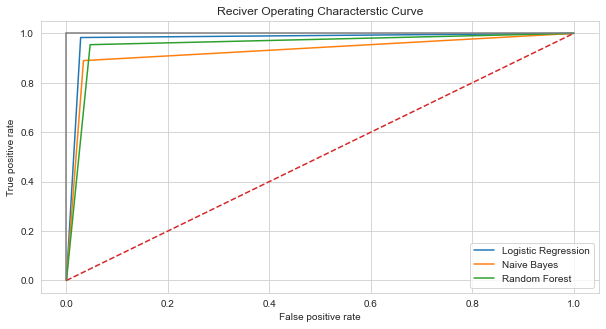

In [21]:
lr_false_positive_rate,lr_true_positive_rate,lr_threshold = roc_curve(y_test,lr_predict)
nb_false_positive_rate,nb_true_positive_rate,nb_threshold = roc_curve(y_test,nb_predicted)
rf_false_positive_rate,rf_true_positive_rate,rf_threshold = roc_curve(y_test,rf_predicted)                                                             

sns.set_style('whitegrid')
plt.figure(figsize=(10,5))
plt.title('Reciver Operating Characterstic Curve')
plt.plot(lr_false_positive_rate,lr_true_positive_rate,label='Logistic Regression')
plt.plot(nb_false_positive_rate,nb_true_positive_rate,label='Naive Bayes')
plt.plot(rf_false_positive_rate,rf_true_positive_rate,label='Random Forest')
plt.plot([0,1],ls='--')
plt.plot([0,0],[1,0],c='.5')
plt.plot([1,1],c='.5')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.legend()
plt.show()